# Машина опорных векторов

Dataset: [armenian pubs](https://www.kaggle.com/erikhambardzumyan/pubs)

Подробнее о данных можно узнать в [первой работе](https://github.com/andrgolubev/python-sandbox/blob/master/data_analysis_1.ipynb)

## Плюсы и минусы машины опорных векторов

**Плюсы**

* Эффективны в многомерных пространствах
* Все еще эффективны, если N в N-мерном пространстве больше, чем количество примеров выборки
* Можно использовать различные ядра (kernels) для улучшения результата (в том числе, свои собственные)

**Минусы**

* Если количество признаков много больше, чем количество примеров, можно ожидать переобучения (overfitting) при выборе ядер. Становится очень важна регуляризация
* Сама машина опорных векторов не предоставляет вероятностных оценок

#### Перекрывающиеся классы

Математическая постановка задачи:
$$ 
\beta, \beta_0, \xi = \mathop{\rm argmin}_{\beta, \beta_0, \xi} \frac{1}{2} \|\beta\|^2 
+ C \sum_{i=1}^N \xi_i
$$
при ограничениях
$$
y^{(i)} (\beta^{\top}x^{(i)} + \beta_0) \ge 1 - \xi_i,
\qquad
\xi_i \ge 0
\qquad
(i = 1,2,\dots, N)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Наши данные

In [2]:
import data_retrieve as dr
X, data = dr.parse_and_prepare("armenian_pubs.csv", sep=",", engine="python")
Y = None
Y_numeric = data['wts']
Y_mean = np.mean(Y_numeric)
Y = pd.Series(['C1' if val <= Y_mean else 'C2' for val in Y_numeric])
intY = pd.Series([0 if val is 'C1' else 1 for val in Y])
feature_names = X.columns
print(feature_names)

Index(['age', 'income', 'occupation_CEO',
       'occupation_Entrepreneur_/_Software_Engineer', 'occupation_Student',
       'occupation_Student_+_working', 'occupation_Working',
       'occupation_Working', 'occupation_army', 'freq_Several_times_a_week',
       'freq_Several_times_in_a_month', 'freq_rarely', 'prim_imp_Environment',
       'prim_imp_Menu', 'prim_imp_Music', 'prim_imp_Pricing',
       'sec_imp_Environment', 'sec_imp_Menu', 'sec_imp_Music',
       'sec_imp_Pricing', 'stratum_Capital', 'stratum_Rural', 'stratum_Urban',
       'lifestyle_Adventure/traveling/exploring', 'lifestyle_Art',
       'lifestyle_Business_sports_dance', 'lifestyle_Busy',
       'lifestyle_Nightlife', 'lifestyle_Passive', 'lifestyle_Rock_punk',
       'lifestyle_Sport', 'lifestyle_Sport_art_traveling', 'lifestyle_Student',
       'occasions_Birthdays', 'occasions_For_listening__good_music',
       'occasions_Hang_outs_with_friends', 'occasions_Never',
       'occasions_Nowere', 'occasions_Special_eve

#### Разбиение на обучающую и тестовую выборки

In [4]:
from sklearn.model_selection import train_test_split
# constant random_state to have repeatability
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state=7)
N_train, _ = X_train.shape
N_test, _ = X_test.shape
intY = pd.Series([0 if val is 'C1' else 1 for val in Y_train])
print(N_train, N_test)

122 53


#### Инициализация

In [69]:
from sklearn.svm import SVC # "Support Vector Classifier"
svc_model = SVC(kernel = 'linear')
svc_model.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

(0.0, 1.0)

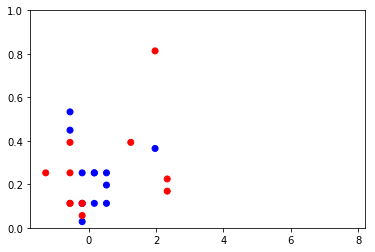

In [72]:
x0_min, x0_max = plt.xlim()
x1_min, x1_max = plt.ylim()
vX = X_train.values
colors = np.array(['b', 'r'])[intY]
plt.scatter(vX[:, 0], vX[:, 1], color = colors)
plt.ylim((x1_min, x1_max))
# draw_sep_curve(svc_model)

#### Опорные векторы

In [105]:
print("X.shape: ", X.shape)
print("len(support_vectors_[i]): ", len(svc_model.support_vectors_[0]))
print("Number of support vectors for each class: ", svc_model.n_support_)
print("Support vectors:\n", svc_model.support_vectors_)

X.shape:  (175, 41)
len(support_vectors_[i]):  41
Number of support vectors for each class:  [50 45]
Support vectors:
 [[-0.55899819 -0.13988381  0.         ...,  0.          0.          0.        ]
 [-0.91997488 -0.3081405   0.         ...,  0.          0.          0.        ]
 [-0.55899819  0.53314297  0.         ...,  0.          0.          1.        ]
 ..., 
 [ 1.24588526  0.39292906  0.         ...,  0.          0.          0.        ]
 [-0.1980215  -0.22401216  0.         ...,  1.          0.          1.        ]
 [-0.1980215  -0.3081405   0.         ...,  0.          0.          1.        ]]


### Ядро

Ядро задает скалярное произведение в спрямленном пространстве.

___Линейное ядро___ – это обычное скалярное произведение: $k(x, x') = x^{\top} x'$ – спрямленное пространство совпадает с исходным.

___Радиальное ядро___: $k(x, x') = e^{-\gamma \|x-x'\|^2}$ задается _радиальной функцией_ (Radial Basis Function): $r = e^{-\gamma(x_1^2 + x_2^2 + \dots + x_d^2)}$

___Полиномиальное ядро___: $k(x, x') = (\gamma\, x^{\top} x' + c_0)^{\delta}$

___Сигмоидальное ядро___: $k(x, x') = \mathop{\rm th}(\gamma x^{\top} x' + c_0),
\qquad \mathop{\rm th} x = \frac{e^x- e^{-x}}{e^x + e^{-x}}$, где
_гиперболический тангенс_ $\mathop{\rm th} x$ – это тот же элементарный сигмоид, только сдвинутый и растянутый по вертикальной оси.

#### Ошибки для разных ядер при разной регуляризации

In [114]:
from ipywidgets import interact

_, n_features = X.shape
def print_svc_data(kernel='linear', C=1.0):
    svc_model_modified = SVC(kernel=kernel, C=C, probability=True)
    svc_model_modified.fit(X_train, Y_train)
    print("Number of support vectors for each class: ", svc_model_modified.n_support_)
    err_train = np.mean(Y_train != svc_model_modified.predict(X_train))
    err_test = np.mean(Y_test != svc_model_modified.predict(X_test))
    print(f"Errors: train - {err_train} | test - {err_test}")
    print("Constants in decision function: ", svc_model_modified.intercept_)
    pass

interact(print_svc_data, kernel=['linear', 'poly', 'rbf', 'sigmoid'], C=(0.01, 20.01, 0.1))
pass

#### Для большей наглядности рассмотрим пример со сгенерированными данными

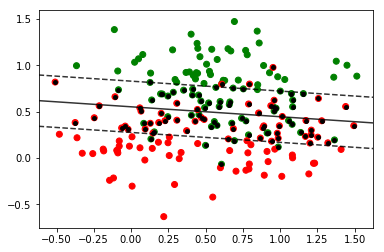

In [161]:
import mysk
from IPython import display

X, y = mysk.generate_points(seed = 0)
X_tst, y_tst = mysk.generate_points(seed = 7)
def print_svc_gen(kernel='linear', C=1.0):
    svc_model_gen = SVC(kernel=kernel, C=C, probability=True)
    svc_model_gen.fit(X, y)
    print("Number of support vectors for each class: ", svc_model_gen.n_support_)
    err_train = np.mean(y != svc_model_gen.predict(X))
    err_test = np.mean(y_tst != svc_model_gen.predict(X_tst))
    print(f"Errors: train - {err_train} | test - {err_test}")
    print("Constants in decision function: ", svc_model_gen.intercept_)
    plt.scatter(X[:, 0], X[:, 1], color = np.array(['g', 'r'])[y])
    draw_sep_curve(svc_model_gen)
    plt.scatter(svc_model_gen.support_vectors_[:, 0], svc_model_gen.support_vectors_[:, 1],
                s = 15, facecolors = 'k')
    pass

interact(print_svc_gen, kernel=['linear', 'poly', 'rbf', 'sigmoid'], C=(0.01, 20.01, 0.1))
pass

Черным обозначены опорные векторы